<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDNet_Expriment_GoogleNet_SVBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate
from keras import regularizers

In [2]:
!unzip -qq images.zip

In [3]:
!unzip -qq labels.zip

In [4]:
from PIL import Image,ImageOps
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:5000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_gray = Image.open(labels_folder+image_name).convert('L')
      label_image = array(label_gray)
      #img = Image.open('input_file.jpg').convert('L')
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return class_label,label,total_img

In [5]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [6]:
total_images.shape

(5000, 224, 224, 3)

In [7]:
total_labels.shape

(5000, 224, 224)

In [8]:
class_labels.shape

(5000,)

In [9]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [10]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=1, activation='sigmoid', name=name)(layer)
    return layer

In [22]:
def ident_auxiliary(x,name=None):
  dec3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)#28*28*512
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same")(dec7)#224*224*1
  #FusionNetwork
  Upsam_Deep = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Deep,Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same")(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_Shallow])
  Axilary_final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005),name=name)(concatted_all) #224*224*1
  return Axilary_final_output

In [24]:

def identifier(x,name=None):
  dec2 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x) #14*14*512
  dec3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(dec2)#28*28*256
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same")(dec7)#224*224*1
  #FusionNetwork1
  Upsam_Deep1 = layers.Conv2DTranspose(128, (3, 3), strides=32, activation="relu", padding="same")(x)
  Upsam_Deep2 = layers.Conv2DTranspose(128, (3, 3), strides=16, activation="relu", padding="same")(dec2)
  Upsam_Deep3 = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  concatted_deep = tf.keras.layers.Concatenate(axis=3)([Upsam_Deep1,Upsam_Deep2,Upsam_Deep3])
  result_concatted_deep= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same")(concatted_deep) #224*224*1
  #FusionNetwork2
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",)(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_deep,result_concatted_Shallow])
  final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid",name=name, padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005))(concatted_all) #224*224*1
  return final_output


In [25]:

def googlenet():
  layer_in = Input(shape=(224, 224, 3))  
  # stage-1
  layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  layer = BatchNormalization()(layer)
  # stage-2
  layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
  layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-3
  layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
  layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-4
  layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
  ident1  = ident_auxiliary(layer, name='ident1')
  aux1  = auxiliary(layer, name='aux1')
  layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
  layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
  layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
  ident2 =ident_auxiliary(layer, name='ident2')
  aux2  = auxiliary(layer, name='aux2')
  layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-5
  layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
  layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
  ident  = identifier(layer, name='ident')
  layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
  # stage-6
  layer = Flatten()(layer)
  layer = Dropout(0.4)(layer)
  layer = Dense(units=256, activation='linear')(layer)
  main = Dense(units=1, activation='sigmoid', name='main')(layer)  
  model = Model(inputs=layer_in, outputs=[main, aux1, aux2,ident,ident1,ident2]) 
  return model

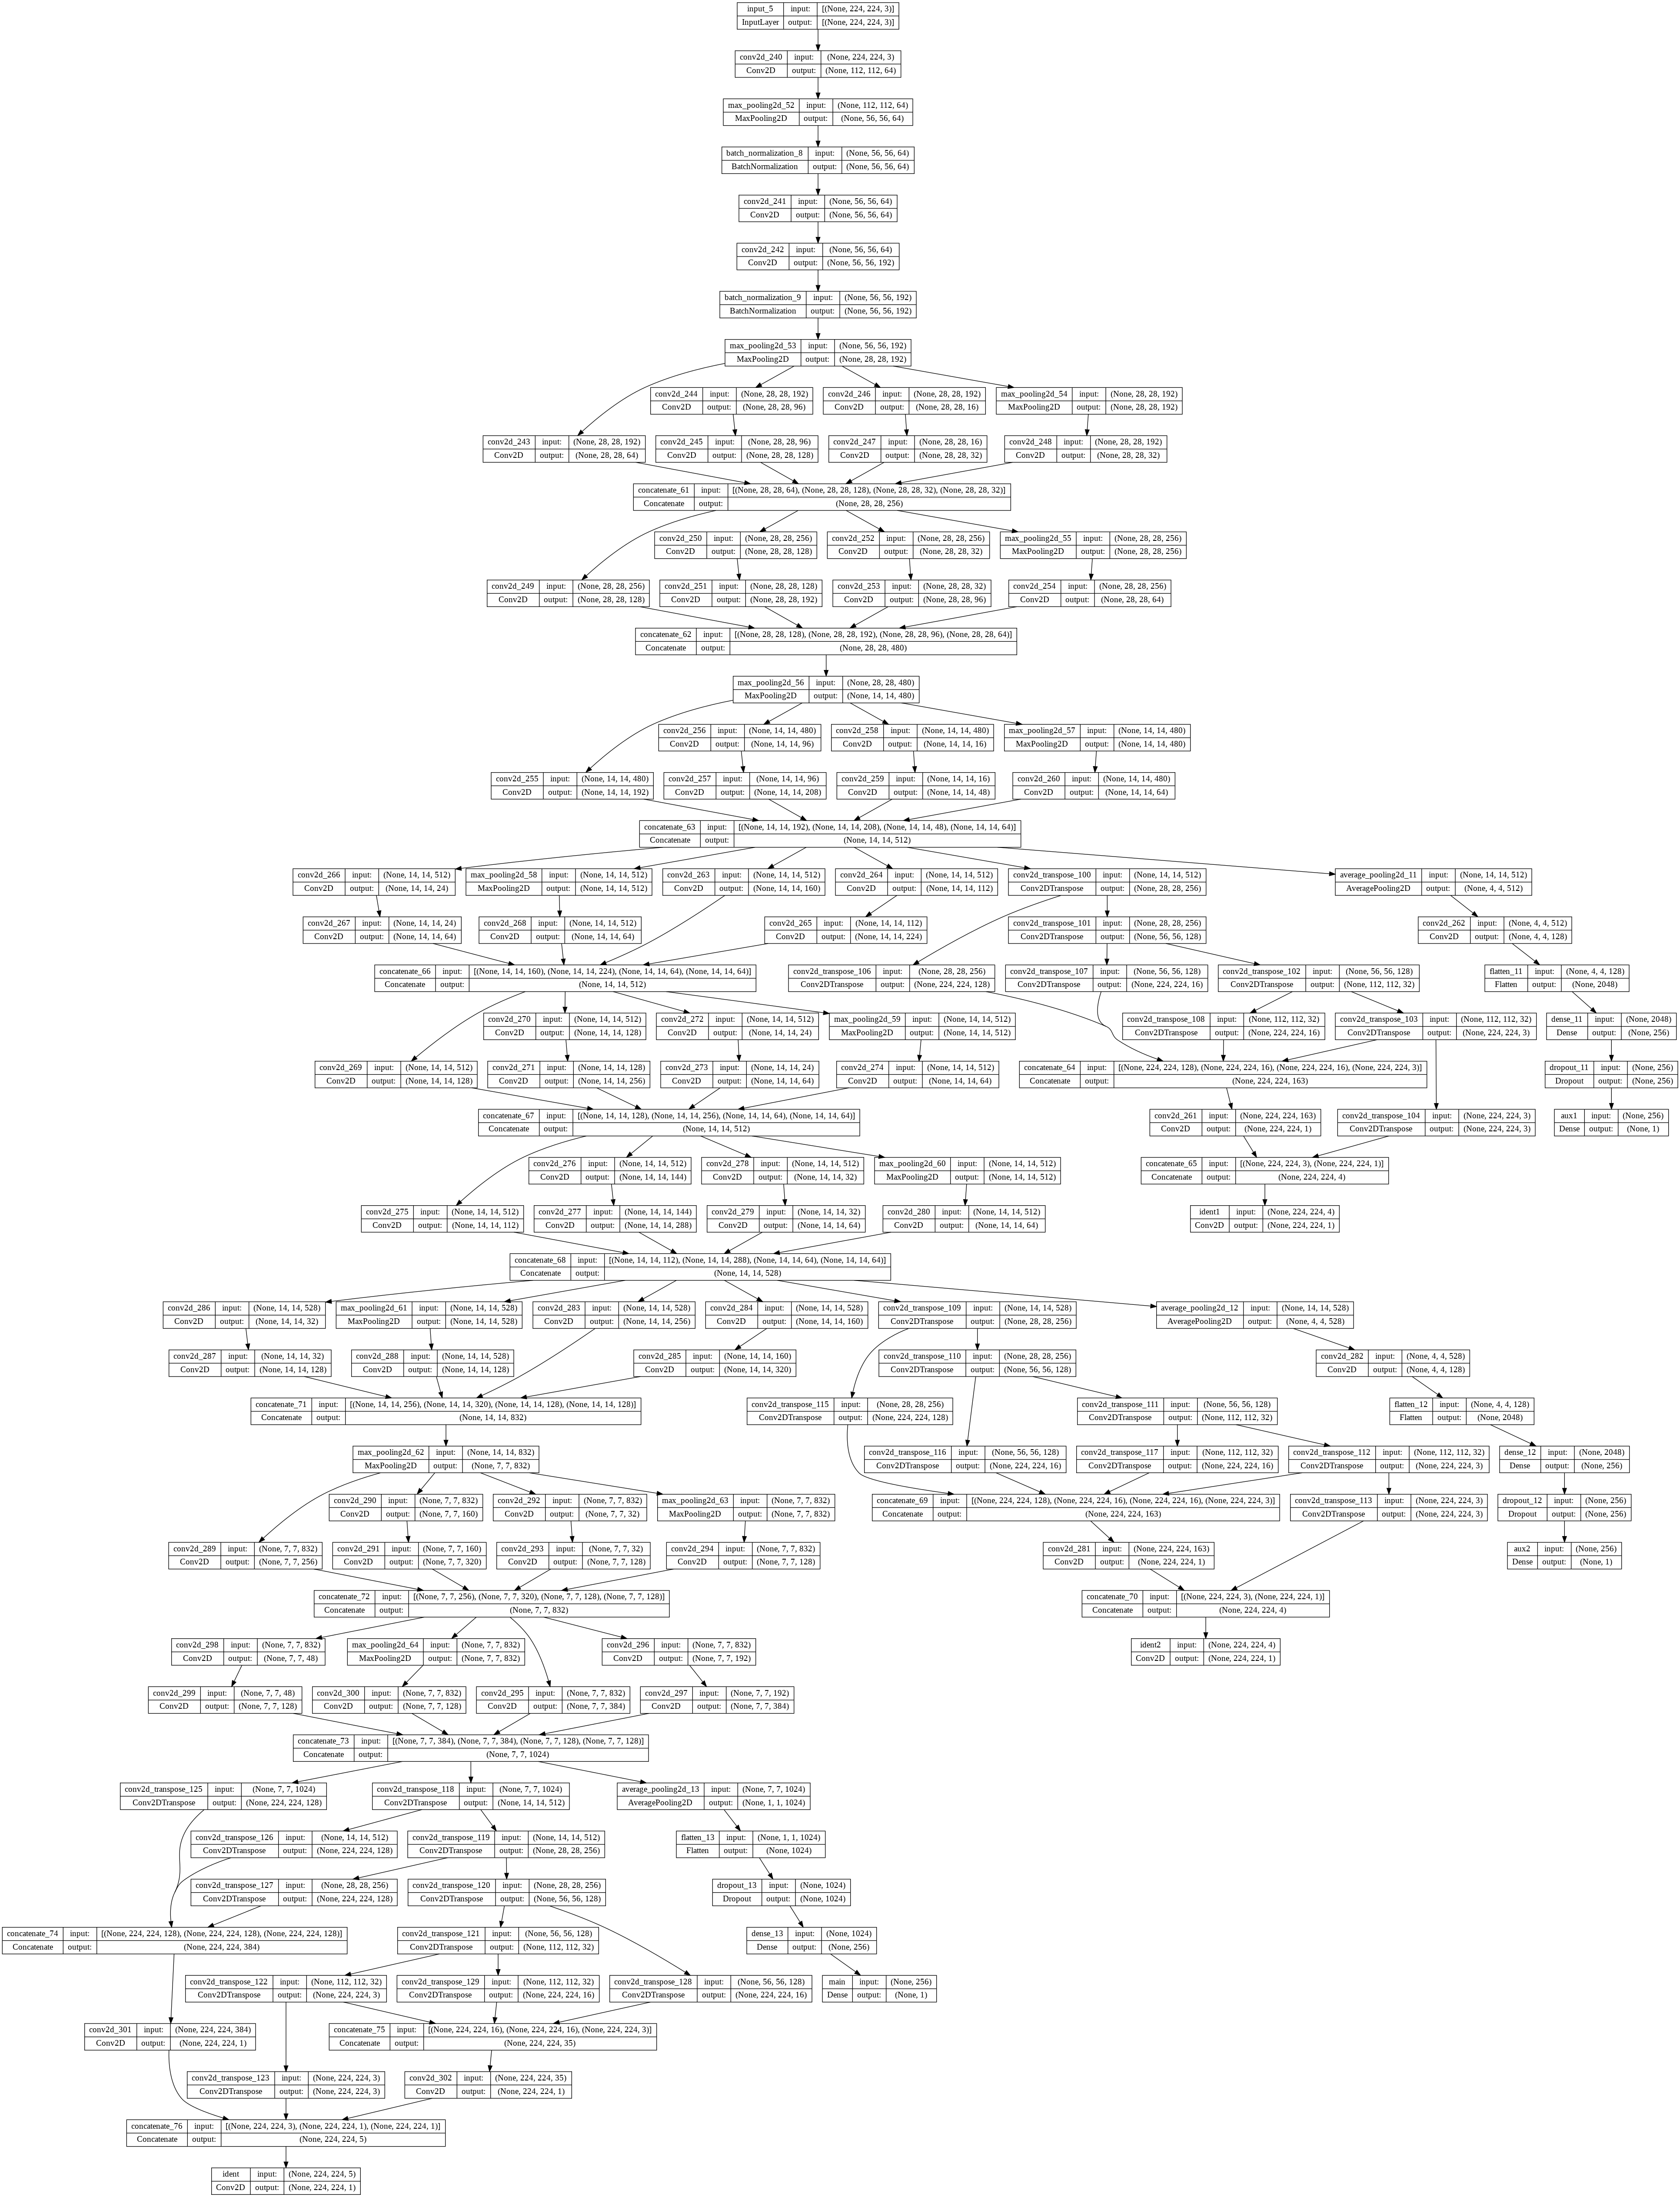

In [26]:
model = googlenet()
keras.utils.plot_model(model, show_shapes=True)

In [28]:
class_label=class_labels[:2000]
x_train = total_images[:2000].astype(np.float32)/ 255.0
y_train = total_labels[:2000].astype(np.float32)/ 255.0
y_train = (y_train,class_label)

In [30]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        loss = logs["val_ident_loss"]
        if loss <= self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.0170)]

In [32]:
(y_train[0][0]).shape

(224, 224)

In [33]:
loss1="binary_crossentropy"
loss2=tf.keras.losses.MeanSquaredError()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss1,loss1,loss2,loss2,loss2],metrics=["accuracy"])

In [34]:
history = model.fit(x_train,[y_train[1],y_train[1],y_train[1],y_train[0],y_train[0],y_train[0]], epochs=55,batch_size=20,validation_split=0.2,shuffle=True,callbacks=[callbacks])
model.save('sbdnet_expriment_googlenet_svbi.h5')

Epoch 1/55
80/80 [==============================] - 76s 670ms/step - loss: 2.4905 - main_loss: 0.7204 - aux1_loss: 0.7552 - aux2_loss: 0.7118 - ident_loss: 0.0942 - ident1_loss: 0.0977 - ident2_loss: 0.0895 - main_accuracy: 0.5025 - aux1_accuracy: 0.5238 - aux2_accuracy: 0.5000 - ident_accuracy: 0.9094 - ident1_accuracy: 0.9034 - ident2_accuracy: 0.9000 - val_loss: 2.3275 - val_main_loss: 0.6927 - val_aux1_loss: 0.6924 - val_aux2_loss: 0.6930 - val_ident_loss: 0.0731 - val_ident1_loss: 0.0847 - val_ident2_loss: 0.0713 - val_main_accuracy: 0.5225 - val_aux1_accuracy: 0.5000 - val_aux2_accuracy: 0.5225 - val_ident_accuracy: 0.9189 - val_ident1_accuracy: 0.9172 - val_ident2_accuracy: 0.9189
Epoch 2/55
80/80 [==============================] - 51s 641ms/step - loss: 2.2745 - main_loss: 0.6942 - aux1_loss: 0.6594 - aux2_loss: 0.6907 - ident_loss: 0.0703 - ident1_loss: 0.0733 - ident2_loss: 0.0678 - main_accuracy: 0.4888 - aux1_accuracy: 0.5944 - aux2_accuracy: 0.5050 - ident_accuracy: 0.9219

In [35]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'main_loss', 'aux1_loss', 'aux2_loss', 'ident_loss', 'ident1_loss', 'ident2_loss', 'main_accuracy', 'aux1_accuracy', 'aux2_accuracy', 'ident_accuracy', 'ident1_accuracy', 'ident2_accuracy', 'val_loss', 'val_main_loss', 'val_aux1_loss', 'val_aux2_loss', 'val_ident_loss', 'val_ident1_loss', 'val_ident2_loss', 'val_main_accuracy', 'val_aux1_accuracy', 'val_aux2_accuracy', 'val_ident_accuracy', 'val_ident1_accuracy', 'val_ident2_accuracy'])


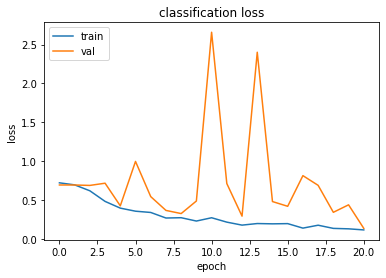

In [36]:
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.title('classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

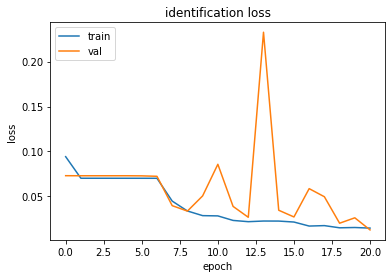

In [37]:
plt.plot(history.history['ident_loss'])
plt.plot(history.history['val_ident_loss'])
plt.title('identification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()   

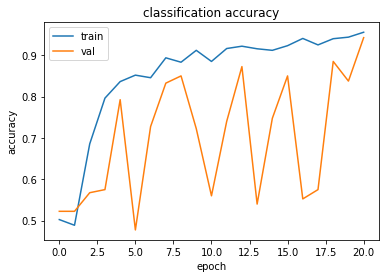

In [38]:
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()    

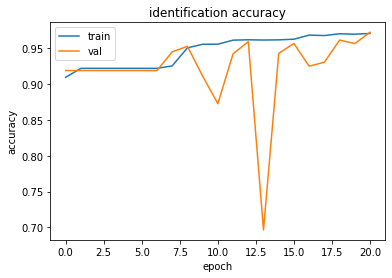

In [39]:
plt.plot(history.history['ident_accuracy'])
plt.plot(history.history['val_ident_accuracy'])
plt.title('identification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
eval_images=total_images[2500:3500]
eval_labels=total_labels[2500:3500]
eval_class_label=class_labels[2500:3500]

In [ ]:
from keras.models import load_model
model = load_model("sbdnet_expriment_googlenet_svbi.h5")
images = eval_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [42]:
((predictions[0][3])[0]).shape

(224, 224, 1)

In [43]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=(((predictions[i])[0])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)
y_pred_class=np.array(y_pred_class)

## Confusion Matrix

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[452,  35],
       [ 14, 499]])

In [45]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       487
         1.0       0.93      0.97      0.95       513

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



## Average IoU

In [90]:
ground_truth_total=eval_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

In [91]:
def get_iou_score(true_label, y_pred_label):
  iou_scores=[]
  for i in range(0,len(true_label)):
    pp=np.where((((predictions[i])[3])[0])>0.5,1.0,0.0)
    pp=reshape(pp,[224,224])
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label[i],pp)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)
iou_score= get_iou_score(ground_truth_total,predictions)
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.919333


Mean Absolute Error MAE

In [92]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    pp=np.where((((predictions[i])[3])[0])>0.5,1.0,0.0)
    y_pred=pp
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total, predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)
     

Mean Absolute Error for Evaluation set:  0.10861890858463923


## F-measure score

In [84]:
pred_labels_total=[]
for i in range(len(predictions)):
  hh = ((predictions[i])[3])[0]
  hh = hh[:,:,0]
  pred_labels_total.append(hh)
pred_labels_total=np.array(pred_labels_total)

In [99]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2 = 0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i]))>thr,1.0,0.0)
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,pred_labels_total)

In [101]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('F-measure score: ',mean_Fb_score)

F-measure score:  0.914286389565912


predicted Blur Map for 100 test images from SVBI dataset


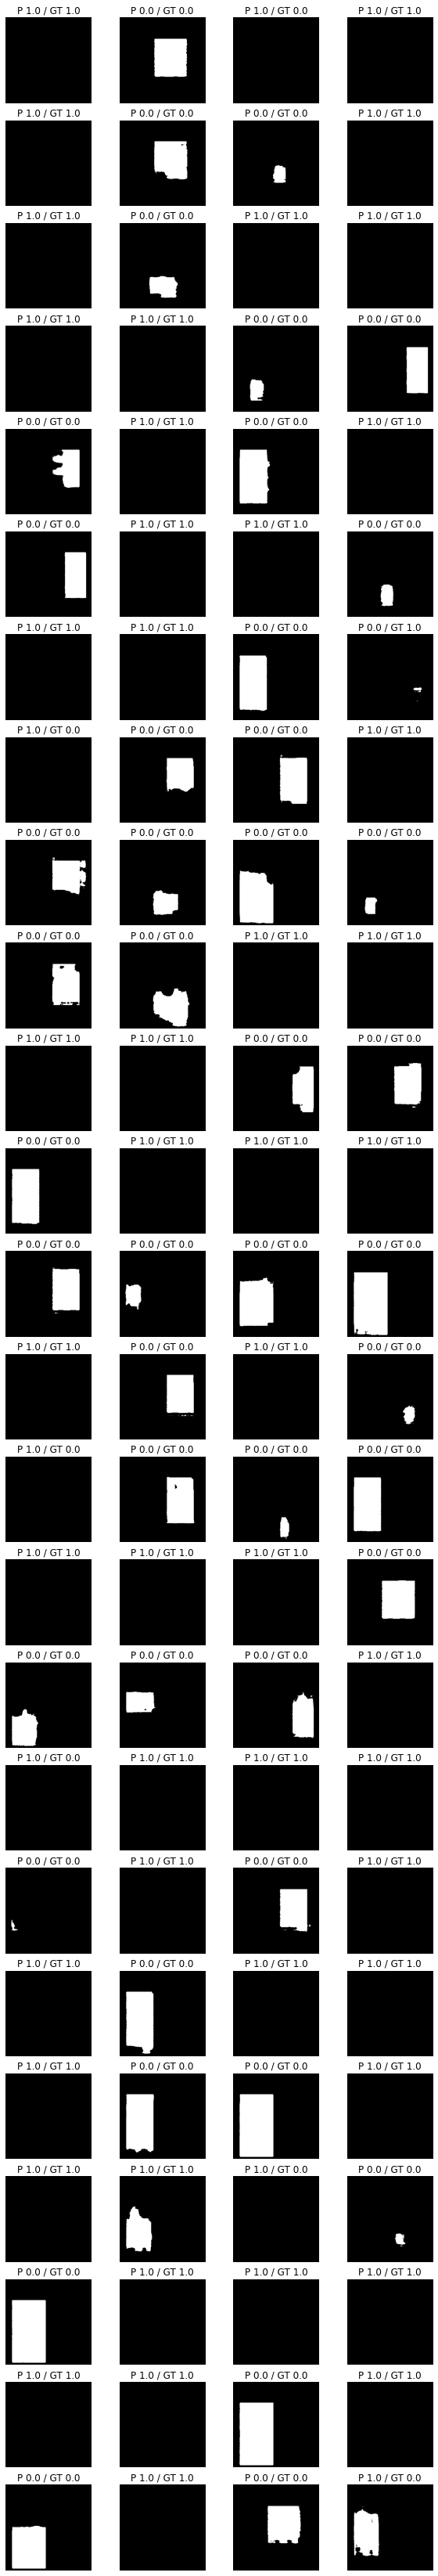

In [103]:
columns = 4
rows = 25
print("predicted Blur Map for 100 test images from SVBI dataset")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[3])[0])>0.5,1.0,0.0)
  #img_pred_label=(predictions[i])[0]
  plt.imshow(reshape(img_pred_label*255.0,[224,224]),cmap='gray')
  predicted_class=y_pred_class[i]
  plt.title(f"P {predicted_class} / GT {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()

100 test images from SVBI with predicted Mask 


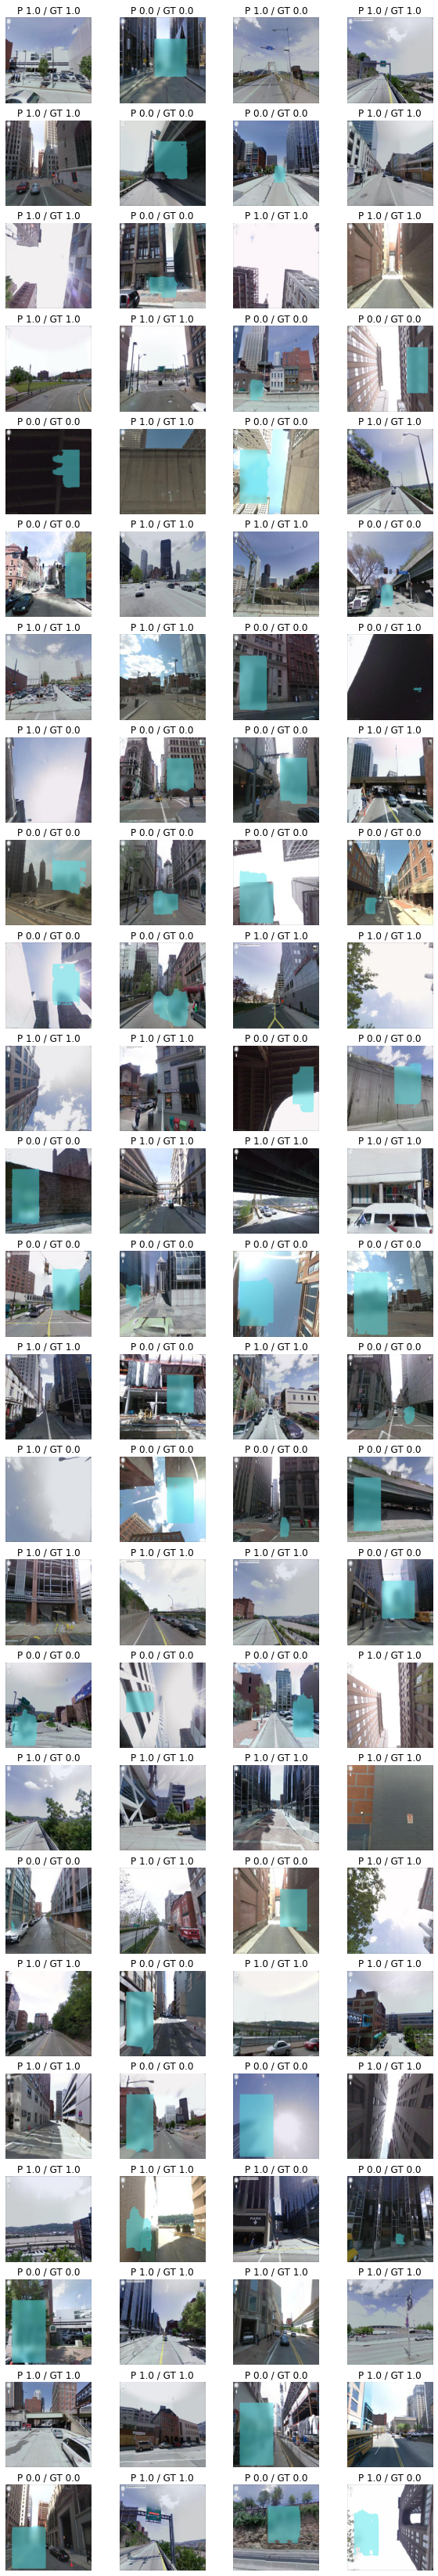

In [106]:
fig = plt.figure(figsize=(10,60))
columns = 4
rows = 25
print("100 test images from SVBI with predicted Mask ")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[3])[0])>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  plt.imshow(mask,cmap='binary')
  predicted_class=y_pred_class[i]
  plt.title(f"P {predicted_class} / GT {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()

100 test images from SVBI


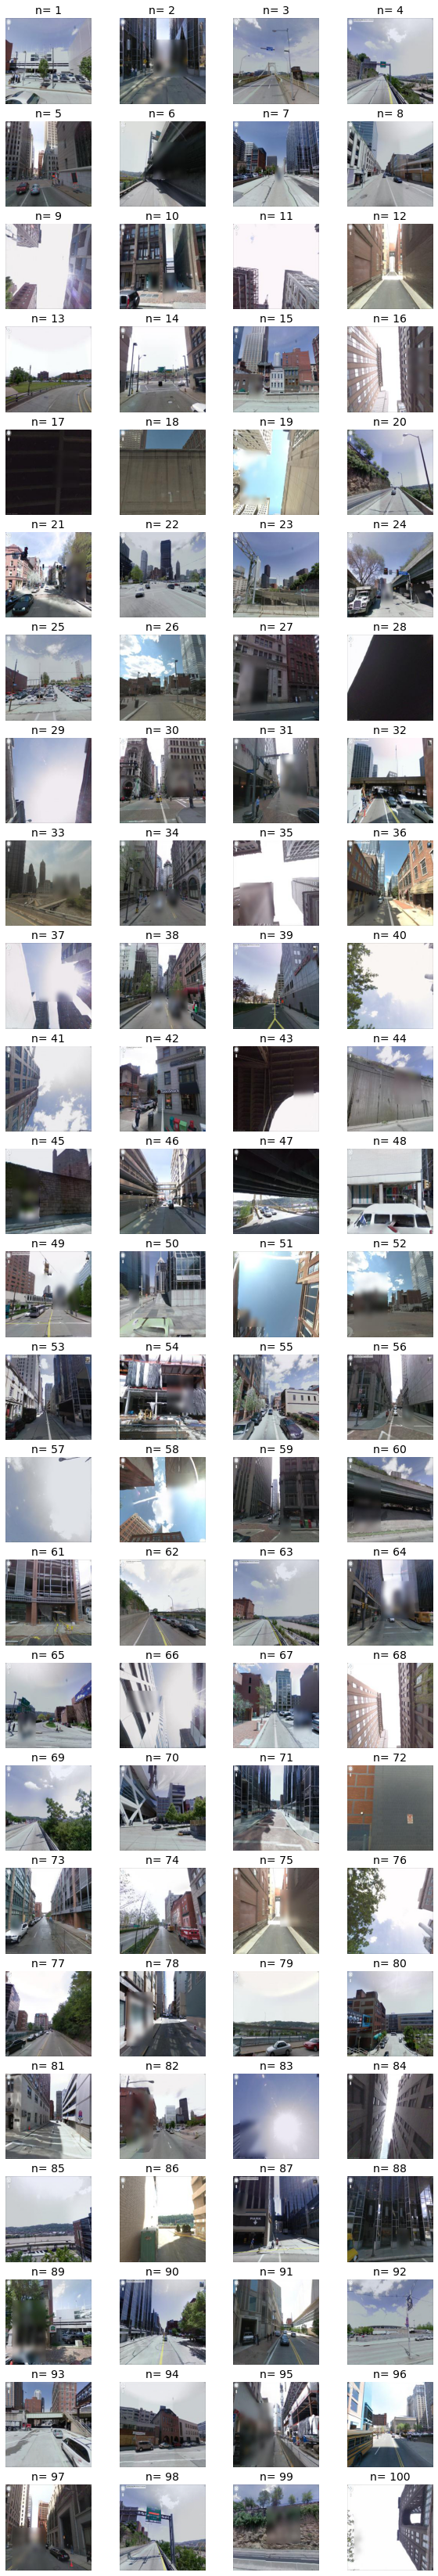

In [107]:
columns = 4
rows = 25
print("100 test images from SVBI")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()


GT of 100 images from SVBI


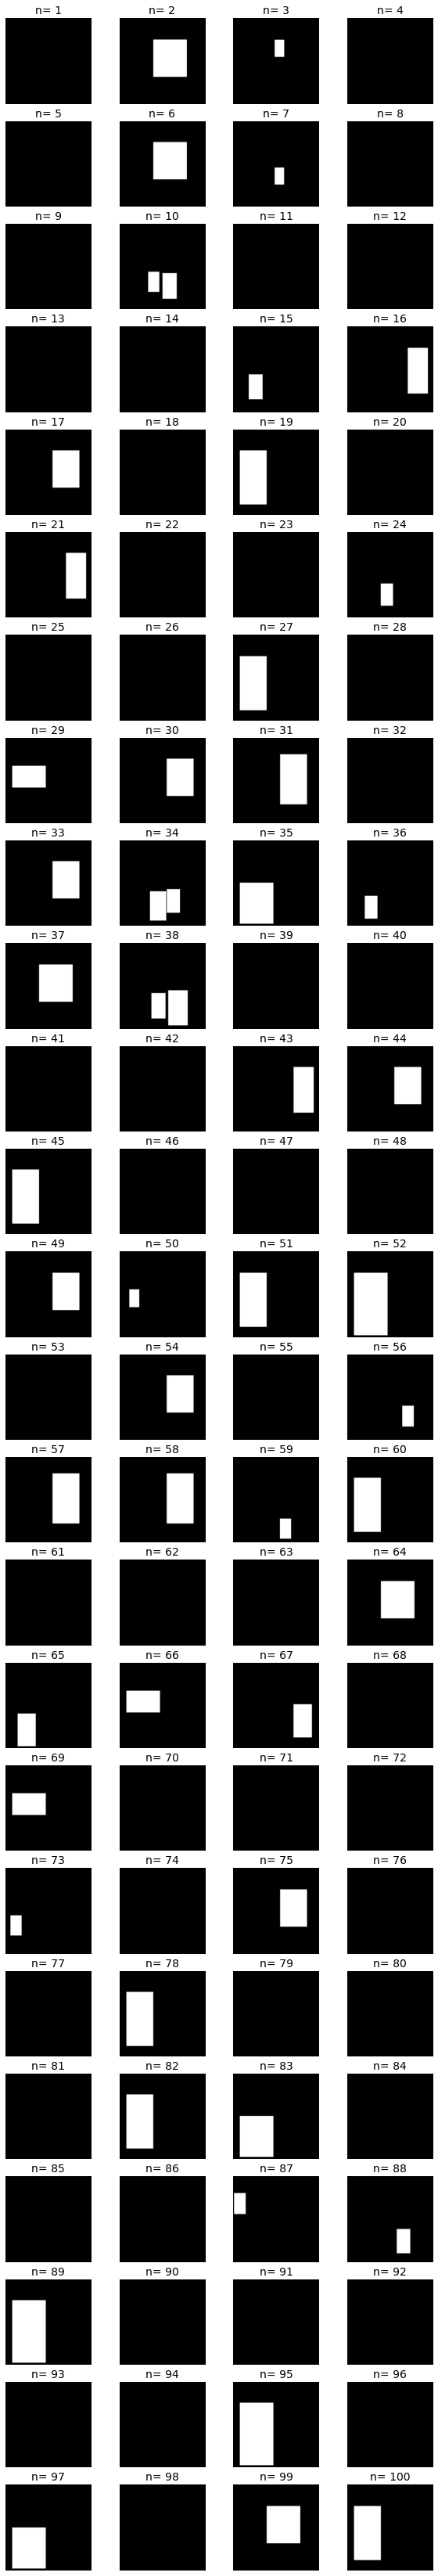

In [112]:
columns = 4
rows = 25
print("GT of 100 images from SVBI")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i],cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()